In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model as lm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from stop_words import get_stop_words
import Stemmer
import pymorphy2
from segtok import segmenter
import re
from functools import partial
import pickle
import xgboost as xgb 
%matplotlib inline

/home/digitman/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading data

In [2]:
data = pd.read_csv('data/comments_vrn.csv.gz')

In [3]:
data.shape

(193539, 6)

In [4]:
data.is_gum.value_counts()

0.0    111199
1.0     82340
Name: is_gum, dtype: int64

In [5]:
data.head(3)

,from_id,text,is_gum,hour,likes,sex
0,170328895,А еще сегодня у нас в Советском районе нашлы м...,1.0,13,9,1
1,170328895,"[id231306085|Алиса], не слышала такой информац...",1.0,13,0,1
2,170328895,"Алиса, хорошо бы ,у нас ни от кого такой инфор...",1.0,13,0,1


## Examples of two classes

In [6]:
data[data.is_gum == False].text.sample(10).values

array(['все улицы залиты', '[id159140514|Денис], не все!1!!',
       'погугли!\nhttp://ru.wikipedia.org/wiki/%C2%F1%EF%EE%EC%ED%E8%F2%FC_%E2%F1%B8_(%F4%E8%EB%FC%EC,_1990)',
       '[id12422137|Илья], ага, прикинь сколько ты отдашь, когда при досмотре тебе подкинут пакетик, чтобы не отправится на стул',
       '[id293169571|Эльдар], ахаха...имеется',
       '[id196185878|Олег], или в мусоропровод',
       'Я вот знаю, что уже двое мужиков похожих заластали', 'Косячок )))',
       'я в детстве пластилином по прохожим кидался))))а тут чет жестко как то бетонными глыбами , суровое поколение:D',
       '[id140593667|Юля], Ну, если Северный с Коминтерном ещё не разделили. А Олимпик вообще относится к ЦЕНТРУ(!!!) - думаю, проводящие границы или спят или что-то хорошее употребляют. :-)\nP/S/ То же самое с "Советский" и Юго-Западный.'], dtype=object)

In [7]:
data[data.is_gum == True].text.sample(10).values

array(['[id210347151|Мария], 4',
       '[id17699181|Юля], значит и фанаты такие же, высоко разумные вы уж простите, а то как реп слушать, так там наркоманы, а как тут горшок умер от наркоты и вёл далеко аморальный образ жизни так это великий',
       'набираем желающих заниматься боксом (парней/девушек) а также тренажёрный зал + индивидуальные занятия',
       '[id10396703|Кирюха], Да тут все лишь бы языки почесать, вроде завтра в школу спать пора',
       '[id224419568|Олег], 14',
       'Причём тут выборы и программа общественного транспорта Гордеева...',
       'Алан Милн - «Винни Пух» был написан в 1925 и опубликован в 1926 году.',
       'Одобрили мою картинку,значит))', '[id1417542|Ярослав], ты идиот😉',
       'А в инете разве нету?'], dtype=object)

# Preprocessing

## Words count

In [8]:
lenghts_word = np.array([len(m.split()) for m in data.text.values])

In [9]:
lenghts_word.mean(), np.median(lenghts_word)

(11.219397640785578, 6.0)

In [10]:
comments = data[(lenghts_word < 20) & (lenghts_word > 1)]
comments.shape

(147584, 6)

## Links

In [11]:
links = [m for m in data.text.values if 'http' in m or 'www' in m or '.ru' in m or '.com' in m] 
print('{:.2f}% of comments contain links'.format(len(links) / len(data) * 100))

0.46% of comments contain links


In [12]:
without_link = [False if 'http' in c or 'www' in c or '.ru' in c or '.com' in c else True
                for c in comments.text.values] 

In [13]:
comments = comments[without_link]

In [14]:
comments.shape

(146955, 6)

In [15]:
lenghts_word = np.array([len(m.split()) for m in comments.text.values])

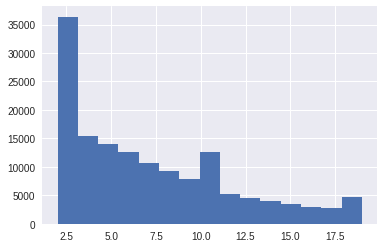

In [16]:
plt.hist(lenghts_word, bins=15);

# Droping outliers

## Emoji

In [18]:
comments_list = comments.text.values

In [19]:
with open('meta_data/emoji.txt', 'r') as f:
    lines = f.readlines()
emojis = [line[0] for line in lines]

In [20]:
def is_with_emoji(comment):
    for em in emojis:
        if em in comment:
            return 1
    return 0

In [21]:
def with_emoji(comments):
    return [is_with_emoji(c) for c in comments]

In [22]:
def get_emoji(comment, repetition=True):
    ems = []
    for em in emojis:
        if not repetition:
            if em in comment:
                ems.append(em)
        else:
            founded = re.findall(em, comment)
            if len(founded) > 0:
                ems.extend(founded)
    return ems

In [24]:
def get_emoji_proportion(comments, emoji_from_coms=None, repetition=True):
    emoji_proportion = [] 
    func = lambda com: get_emoji(com, repetition)
    if not emoji_from_coms:
        emoji_from_coms = list(map(func, comments))
    
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        emoji_proportion.append(len(emoji_from_coms[i]) / len(com))
    return np.array(emoji_proportion)

### Proportion of alphabetical symbols

In [25]:
def get_abc_proportion(comments):
    abc_proportion = []     
    for i in range(len(comments)):
        com = re.sub(' *', '', comments[i])
        abc = re.findall('[а-яёa-z]', com, flags=re.IGNORECASE)
        abc_proportion.append(len(abc) / len(com))
    return np.array(abc_proportion)

In [26]:
abc_proportion = get_abc_proportion(comments.text.values)

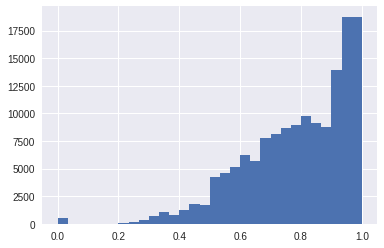

In [27]:
plt.hist(abc_proportion, bins=30);

In [28]:
sum(abc_proportion < 0.3)

1201

In [29]:
comments_list[abc_proportion < 0.3][:10]

array(['89066762448                                    📲',
       '89066762448                                     👻', '48 и 16',
       'Мне 16).\n19-23', '[id221855027|Яна], ...............',
       '[id65018554|Катерина], .............',
       '[id133213774|Валентина], ........................',
       '[id298430272|Наталья], ...................',
       '[id261257368|Ольга], .............',
       '[id206912044|Олежа], ................'], dtype=object)

### Filling DataFrame

In [30]:
comments['abc_proportion'] = abc_proportion

#### If message repeats more than one time - drop (spam)

In [32]:
print('{} different spam comments'.format((comments.text.value_counts() > 1).sum()))

951 different spam comments


In [33]:
print('{} total count of spam comments'
      .format(comments.text.value_counts()[comments.text.value_counts() > 1].values.sum()))

3069 total count of spam comments


### Dropping outlier

In [34]:
spam_comments = comments.text.value_counts()[comments.text.value_counts() > 1].keys()
comments = comments[comments.text.apply(lambda t: t not in spam_comments)]

In [35]:
comments.shape

(143886, 7)

In [36]:
comments_list = comments.text.values

### Replacing id

In [37]:
def replace_id(df):
    comments_list = []
    for comment in df.text.values:
        c = comment.split()
        if c[0].startswith('[id'):
            c[0] = 'имя'
        c_ = []
        for w in c:
            if w.startswith('id'):
                c_.append('имя')
            else:
                c_.append(w)
        comments_list.append(' '.join(c))
    comments_list = np.array(comments_list)
    df.text = comments_list

In [38]:
replace_id(comments)

In [34]:
comments_list[:3]

array(['имя не слышала такой информации ,все боятся )',
       'имя да я тоже именно это и слышала.',
       'имя как то уж слишком большое расстояние между Питером и Придонским))))'], dtype=object)

In [39]:
comments.text = comments_list

In [40]:
y = comments.is_gum.values

# Features

### Is the first letter of sentence upper

In [41]:
def sentence_stat(comments):
    big_letter = []
    sents_count = []
    for comment in comments:
        sents = list(segmenter.split_single(re.sub('(\)+|\.+)', '\n', comment)))
        count = sum([1 for sent in sents if sent and (sent[0].isupper() or 'имя' in sent
                                                      or (len(sent) > 1 and sent[0] == '"' and sent[1].isupper()))])
        total = sum([1 for sent in sents if sent.strip() != ''
                     and re.match('.*[a-zа-яё].*', sent.strip(), flags=re.IGNORECASE)])
        # print(count, total)
        if total:
            big_letter.append(count // total)
        else:
            big_letter.append(1)
        if total > 3:
            total = 4
        if total < 1:
            total = 1
        sents_count.append(total)
    return np.array(big_letter), np.array(sents_count)

In [42]:
%%time
big_letter, sents_count = sentence_stat(comments_list)

CPU times: user 4.29 s, sys: 8 ms, total: 4.3 s
Wall time: 4.31 s


In [43]:
pd.Series(sents_count).value_counts()

1    106023
2     29346
3      6769
4      1748
dtype: int64

In [44]:
pd.Series(sents_count[y.astype(bool)]).value_counts(True)

1    0.716640
2    0.215567
3    0.053652
4    0.014140
dtype: float64

In [45]:
pd.Series(sents_count[~y.astype(bool)]).value_counts(True)

1    0.751955
2    0.195277
3    0.042108
4    0.010661
dtype: float64

In [46]:
pd.Series(big_letter).value_counts()

1    106973
0     36913
dtype: int64

### Punctuation count in comment

In [47]:
def punctuation_counts(comments, pattern='\(+', partion=False):
    if partion:
        return [sum(len(p) for p in re.findall(pattern, c)) / len(c) for c in comments]
    else:
        return [1 if len(re.findall(pattern, c)) > 0 else 0 for c in comments]

In [48]:
commas = punctuation_counts(comments_list, pattern='[\.]{2,}', partion=False)

In [49]:
pd.Series(commas).value_counts()

0    128608
1     15278
dtype: int64

### Mean word length

In [50]:
def mean_word_length(comments):
    lengths = []
    for comment in comments:
        comment = comment.lower()
        comment = re.sub('[^а-яё\-]', ' ', comment).split()
        ls = [len(w) for w in comment]
        if len(ls):
            lengths.append(sum(ls) / len(ls))
        else:
            lengths.append(1)
    return lengths

In [51]:
mean_length = mean_word_length(comments_list)

### Caps WORD

In [52]:
def caps_words(comments, partion=False):
    caps = []
    for comment in comments:
        count = len(re.findall('[А-ЯЁA-Z\-]{4,}', comment))
        total = len(comment.split())
        if partion and total != 0:
            caps.append(count / total * 100)
        else:
            caps.append(1 if count > 0 else 0)
    return caps

In [53]:
caps = caps_words(comments_list, False)

In [54]:
pd.Series(caps).value_counts()

0    141411
1      2475
dtype: int64

### English words

In [55]:
def eng_words(comments, partion=False):
    engs = []
    for comment in comments:
        count = len([w for w in re.findall('[a-z\-]{3,}', comment, flags=re.IGNORECASE) if w != 'имя'])
        total = len(comment.split())
        if partion and total != 0:
            engs.append(count / total * 100)
        else:
            engs.append(1 if count > 0 else 0)
    return engs

In [56]:
engs = eng_words(comments_list, False)

In [57]:
pd.Series(engs).value_counts()

0    141805
1      2081
dtype: int64

### Total words

In [58]:
def total_words(comments):
    return [len(com.split()) if len(com.split()) < 25 else 25 for com in comments]

In [59]:
words_count = total_words(comments_list)

In [60]:
pd.Series(words_count).value_counts()[:10]

2     18329
3     15732
4     15271
5     13979
6     12566
7     10667
8      9260
9      7891
10     6844
11     5779
dtype: int64

### Total chars

In [61]:
def total_chars(comments):
    return [len(com) if len(com) < 100 else 100 for com in comments]

In [62]:
chars_count = total_chars(comments_list)

In [63]:
pd.Series(chars_count).value_counts()[:10]

100    6976
18     2852
21     2819
17     2809
20     2809
15     2784
14     2774
19     2769
16     2742
13     2701
dtype: int64

### All comments features together

In [64]:
from sklearn.feature_selection import VarianceThreshold

In [65]:
def get_comments_features(coms):
    features = pd.DataFrame()
    features['with_emoji'] = with_emoji(coms)
    big_letter, sents_count = sentence_stat(coms)
    features['big_letter'] = big_letter
    features['sents_count'] = sents_count
    features['punct_)'] = punctuation_counts(coms, pattern='\)+')
    features['punct_('] = punctuation_counts(coms, pattern='\(+')
    features['punct_?'] = punctuation_counts(coms, pattern='\?+')
    features['punct_!'] = punctuation_counts(coms, pattern='\!+')
    features['punct_..'] = punctuation_counts(coms, pattern='[\.]{2,}')
    features['punct_1-9'] = punctuation_counts(coms, pattern='[0-9]{1,}')
    features['punct_"'] = punctuation_counts(coms, pattern='".+"')
    features['eng_words'] = eng_words(coms, True)
    features['mean_word_len'] = mean_word_length(coms)
    features['caps'] = caps_words(coms)
#     features['em_proportion_rep'] = comments['em_proportion_rep'].values
#     features['em_proportion_no_rep'] = comments['em_proportion_no_rep'].values
    # features['adj_proportion'] = adj_proportion
    features['abc_proportion'] = comments['abc_proportion'].values
    features['words_count'] = total_words(coms)
    features['chars_count'] = total_chars(coms)
    return features

In [66]:
comment_features = get_comments_features(comments_list)

In [67]:
comment_features_list = comment_features.columns.tolist()

In [68]:
comments.columns

Index(['from_id', 'text', 'is_gum', 'hour', 'likes', 'sex', 'abc_proportion'], dtype='object')

In [69]:
comment_features.describe()

,with_emoji,big_letter,sents_count,punct_),punct_(,punct_?,punct_!,punct_..,punct_1-9,"punct_""",eng_words,mean_word_len,caps,abc_proportion,words_count,chars_count
count,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000,143886.000000
mean,0.121186,0.743457,1.334487,0.219813,0.027383,0.173825,0.104479,0.106181,0.094915,0.028703,0.438921,4.667044,0.017201,0.786583,7.310079,41.934233
std,0.326345,0.436727,0.624170,0.414121,0.163197,0.378960,0.305881,0.308071,0.293099,0.166972,4.737411,1.273045,0.130021,0.170274,4.521634,26.544164
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,3.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.875000,0.000000,0.674419,4.000000,20.000000
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.545455,0.000000,0.814815,6.000000,35.000000
75%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.333333,0.000000,0.933333,10.000000,59.000000
max,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,150.000000,37.000000,1.000000,1.000000,19.000000,100.000000


In [70]:
from sklearn import ensemble
from xgboost import XGBClassifier

In [71]:
X = comment_features.values

In [72]:
X.shape

(143886, 16)

In [69]:
rf = ensemble.RandomForestClassifier(100, n_jobs=-1)

In [70]:
baseline_scores = cross_val_score(rf, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.523032301322 0.0133332968428


---

In [102]:
gb = XGBClassifier()

In [103]:
baseline_scores = cross_val_score(gb, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.549046037866 0.0200562149443


---

In [104]:
lr = lm.LogisticRegression()

In [105]:
baseline_scores = cross_val_score(lr, X, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.554863078932 0.015439785092


### Feature selection

In [362]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2, f_regression, mutual_info_regression, RFE,\
     SelectFromModel

In [349]:
sel = VarianceThreshold(0.5)
sel.fit(X, y)
X_ = sel.transform(X)

In [350]:
X_.shape

(131758, 5)

In [100]:
baseline_scores = cross_val_score(lr, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.568997751894 0.00634862669786


In [353]:
baseline_scores = cross_val_score(gb, X_, y, cv=5)
print(baseline_scores.mean(), baseline_scores.std())

0.568572719434 0.00514447862553


In [389]:
list(zip(comment_features.columns.values[sel.get_support()], gb.feature_importances_))

[('punct_1-9', 0.10741301),
 ('eng_words', 0.35249621),
 ('caps', 0.066565812),
 ('chars_count', 0.47352496)]

# Cross validation method

In [92]:
comments = pd.concat((comments.reset_index(drop=True), comment_features.reset_index(drop=True)),
                     axis=1, ignore_index=False)

## Grouping by user

In [74]:
def make_df_balanced(df, by_col):
    """Make df balanced by binary columns named - by_col. Using oversampling"""
    big_class = 0
    small_class = 1
    if df[by_col].value_counts()[0] < df[by_col].value_counts()[1]:
        big_class = 1
        small_class = 0
    
    delta = df[by_col].value_counts()[big_class] - df[by_col].value_counts()[small_class]
    only_ing = df[df[by_col] == small_class]
    to_add_indexes = np.random.randint(0, len(only_ing) - 1, delta)
    df = pd.concat((df, only_ing.iloc[to_add_indexes]))

    # shuffle after adding
    df = df.iloc[np.random.permutation(df.shape[0])]
    return df

In [75]:
def fit_predict_to_n_user(comments, models, n=10, use_cache=True, debug=True, debug_score=True,
                          with_additional=True, predict_proba=False, return_prediction=False):
    unique_ids = None
    if use_cache:
        with open('unique_ids_{}.pkl'.format(n), 'rb') as f:
            unique_ids = pickle.load(f)
    else:
        unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= n].index.values
        additional_ids = comments.from_id.value_counts()[comments.from_id.value_counts() < n].index.values
#         with open('unique_ids_{}.pkl'.format(n), 'wb') as f:
#             pickle.dump(unique_ids, f)
    
    if debug:
        print('{} - uniq peoples'.format(len(unique_ids)))
        print('{} - additional peoples'.format(len(additional_ids)))
    
    train_idxs = unique_ids[:int(len(unique_ids) * 0.8)]
    test_idxs = unique_ids[int(len(unique_ids) * 0.8):]

    train_comments = comments[[i in train_idxs for i in comments.from_id]]
    additional_comments = comments[[i in additional_ids for i in comments.from_id]]
    train_comments = pd.concat((train_comments.reset_index(drop=True), additional_comments.reset_index(drop=True)))

    test_comments = comments[[i in test_idxs for i in comments.from_id]]

    if debug:
        print('Before sampling:')
        print(train_comments.is_gum.value_counts())
        print('Additional comments:')
        print(additional_comments.shape[0])
    
    train_comments = make_df_balanced(train_comments, 'is_gum')
    
    X_train, X_test = train_comments, test_comments
    y_train, y_test = train_comments.is_gum.values, test_comments.is_gum.values
    
    # models
    prediction_df = pd.DataFrame()
    if debug_score:
        print('Accuracy for comment:')
    
    cols = []
    for model in models:
        cols.append(model.name)
        model.fit(X_train, y_train)
        
        if predict_proba:
            prediction = model.predict_proba(X_test)
            if prediction.shape[1] > 1:
                prediction = prediction[:, 1]
            else:
                prediction = prediction.ravel()
        else:
            prediction = model.predict(X_test)
        prediction_df[model.name] = prediction
        
        if debug_score:
            print('Model: ', model.name)
            if predict_proba:
                print(accuracy_score(y_test, prediction > 0.5))
            else:
                print(accuracy_score(y_test, prediction))
                
    if predict_proba:
        prediction_df['prediction'] = prediction_df.mean(axis=1)
    else:
        prediction_df['prediction'] = prediction_df.median(axis=1)
        
    if debug_score:
        if predict_proba:
            print('Mean of models:', accuracy_score(y_test, (prediction_df['prediction'].values > 0.5).astype(int)))
        else:
            print('Median of models:', accuracy_score(y_test, prediction_df['prediction'].values.astype(int)))
    # print(test_comments.shape, prediction_df.shape)
    test_comments = pd.concat((test_comments.reset_index(drop=True), prediction_df.reset_index(drop=True)), axis=1)
    # print(test_comments.shape)
    # test_comments['prediction'] = prediction
    # y_true = test_comments.groupby('from_id').agg(np.median)['is_gum'].values
    # return test_comments
    if predict_proba:
        grouped_median_test = test_comments.groupby('from_id').agg(np.mean)
    else:
        grouped_median_test = test_comments.groupby('from_id').agg(np.median)
    # return test_comments.groupby('from_id')[cols].agg(np.median)
    y_true = grouped_median_test['is_gum'].values
    # print(y_true[:3])
    if debug_score:
        print('Accuracy for user:')

    for model in models:
        y_pred = grouped_median_test[model.name].values
        # print(y_pred[:3])
        # y_pred = np.floor(test_comments.groupby('from_id').agg(np.median)['prediction'].values)
        if debug_score:
            print('Model: ', model.name)
            if predict_proba:
                print(accuracy_score(y_true, (y_pred > 0.5).astype(int)))
            else:
                print(accuracy_score(y_true, y_pred.astype(int)))

    if predict_proba:
        y_pred_proba = grouped_median_test[cols].mean(axis=1).values
        y_pred = (y_pred_proba > 0.5).astype(int)
    else:
        y_pred = np.floor(grouped_median_test[cols].median(axis=1).values).astype(int)
    med_of_models_score = accuracy_score(y_true, y_pred)
    
    if predict_proba:
        y_pred = (grouped_median_test['prediction'].values > 0.5).astype(int)
    else:
        y_pred = np.floor(grouped_median_test['prediction'].values).astype(int)
    med_of_av_models_score = accuracy_score(y_true, y_pred)
    
    if debug_score:
        print('Median of models averaged per user:')
        print(med_of_models_score)
    
    if debug_score:
        print('Median of averaged model per user:')
        print(med_of_av_models_score)
    
    if return_prediction: # for debug
        return med_of_models_score, med_of_av_models_score, prediction_df, y_test
    else:
        return med_of_models_score, med_of_av_models_score

In [76]:
class Model:
    def __init__(self, name='-'):
        self.name = name
        
    def fit(self, X, y):
        raise NotImplemented()
    
    def predict(self, X):
        raise NotImplemented()
    
    def predict_proba(self, X):
        raise NotImplemented()

In [77]:
class LrModelCount(Model):
    def __init__(self, name='-', max_features=1000, analyzer='word', ngram_range=(1, 1), penalty='l2', C=1):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features, analyzer=analyzer, ngram_range=ngram_range)
        self.model = lm.LogisticRegression(penalty=penalty, C=C)
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict(X)
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict_proba(X)

In [78]:
class LrModelCountClear(Model):
    def __init__(self, name='-', max_features=1000):
        super().__init__(name)
        self.vectorizer = CountVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression()
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.clear_text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.clear_text.values)
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.clear_text.values)
        return self.model.predict_proba(X)

In [79]:
class LrModelTfidf(Model):
    def __init__(self, name='-', max_features=1000, penalty='l2', C=1):
        super().__init__(name)
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.model = lm.LogisticRegression(penalty=penalty, C=C)
        self._fitted = False
        
    def fit(self, X, y):
        X = self.vectorizer.fit_transform(X.text.values)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = self.vectorizer.transform(X.text.values)
        return self.model.predict_proba(X)

In [80]:
class FeaturesModelXGB(Model):
    def __init__(self, name='-', n_estimators=100, var_threshold=None, chi2_count=None):
        super().__init__(name)
        self.model = xgb.XGBClassifier(n_estimators=n_estimators)
        if chi2_count is not None:
            self.selector = SelectKBest(chi2, chi2_count)
        elif var_threshold is not None:
            self.selector = VarianceThreshold(var_threshold)
        else:
            raise Exception('var_threshold or chi2_count should be specified!')
        self._fitted = False
        
    def fit(self, X, y):
        X = X[comment_features_list].values
        X = self.selector.fit_transform(X, y)
        self.model.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = X[comment_features_list].values
        X = self.selector.transform(X)
        return self.model.predict(X)

    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        X = X[comment_features_list].values
        X = self.selector.transform(X)
        return self.model.predict_proba(X)

In [81]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.layers.advanced_activations import PReLU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import keras.preprocessing.text
np.random.seed(7)

import xgboost as xgb

Using TensorFlow backend.


In [82]:
class MlpModel(Model):
    def __init__(self, name='-', max_features=1000, neurons=500, clear=False):
        super().__init__(name)
        self.clear = clear
        self.vectorizer = CountVectorizer(max_features=max_features)

        self.model = Sequential()
        self.model.add(Dense(neurons, input_shape=(max_features,)))
        self.model.add(Activation(PReLU()))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1))
        self.model.add(Activation('sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
        X = self.vectorizer.fit_transform(text)
        self.model.fit(X.toarray(), y,
                    nb_epoch=3, batch_size=512,
                    verbose=0) # , validation_split=0.1)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')

        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.transform(text)
        return self.model.predict_classes(X.toarray(), batch_size=512, verbose=0).ravel()
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
            
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.transform(text)
        return self.model.predict(X.toarray(), batch_size=512, verbose=0) #.ravel()

In [83]:
class LstmModel(Model):
    def __init__(self, name='-', nb_words=10000, embedding_vector_length=64, char_level=False, max_len=40,
                 nb_epoch=3, clear=False):
        super().__init__(name)
        self.nb_words = nb_words
        self.embedding_vector_length = embedding_vector_length
        self.char_level = char_level
        self.max_len = max_len
        self.nb_epoch = nb_epoch
        self.clear = clear
        
        self.vectorizer = keras.preprocessing.text.Tokenizer(nb_words=nb_words, lower=True, split=" ",
                                                             char_level=char_level)

        self.model = Sequential()
        self.model.add(Embedding(nb_words, embedding_vector_length))
        self.model.add(Dropout(0.4))
        self.model.add(LSTM(64, return_sequences=True, dropout_W=0.3, dropout_U=0.3))
        self.model.add(Dropout(0.3))
        self.model.add(LSTM(64, return_sequences=False, dropout_W=0.2, dropout_U=0.2))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        
        self._fitted = False
        
    def fit(self, X, y):
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        self.vectorizer.fit_on_texts(text) # clear_coms
        X = self.vectorizer.texts_to_sequences(text)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        
        self.model.fit(X, y, nb_epoch=self.nb_epoch, batch_size=512, verbose=0)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
            
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.texts_to_sequences(text)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict_classes(X, batch_size=512, verbose=0).ravel()
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        
        text = X.text.values
        if self.clear:
            text = X.clear_text.values
            
        X = self.vectorizer.texts_to_sequences(text)
        X = sequence.pad_sequences(X, maxlen=self.max_len, padding='pre')
        return self.model.predict(X, batch_size=512, verbose=0) #.ravel()

## Model selection

### Probability prediction

In [91]:
comments.columns

Index(['from_id', 'text', 'is_gum', 'hour', 'likes', 'sex', 'abc_proportion'], dtype='object')

In [93]:
%%time
np.random.seed(0)
s1, s2, pr, y_t = fit_predict_to_n_user(comments,
        [
#             LstmModel('lstm_word', nb_words=5000, nb_epoch=4),
#             LstmModel('lstm_word_big', nb_words=10000, nb_epoch=5),
#             LstmModel('lstm_word_clear', nb_words=5000, nb_epoch=4, clear=True),
#             LstmModel('lstm_char', nb_epoch=5, nb_words=100, char_level=True, max_len=100),
            
            MlpModel('mlp', neurons=400),
#             MlpModel('mlp_big', max_features=3000, neurons=700),
#             MlpModel('mlp_clear', neurons=400, clear=True),
#             MlpModel('mlp_big_clear', max_features=2000, neurons=600, clear=True),

            LrModelCount('lr_count_2k_word_1', 2000),
            LrModelCount('lr_count_2k_word_12', 2000, ngram_range=(1, 2)),
            LrModelCount('lr_count_2k_word_13', 2000, ngram_range=(1, 3)),

            LrModelCount('lr_count_2k_char_33', 2000, 'char', (3, 3)),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3)),

            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2)),
            LrModelCount('lr_count_5k_word_13', 5000, ngram_range=(1, 3)),
            
            LrModelCount('lr_count_10k_word_13', 10000, ngram_range=(1, 3)),
            
            LrModelCount('lr_count_5k_char_33', 5000, 'char', (3, 3)),
            LrModelCount('lr_count_5k_char_23', 5000, 'char', (2, 3)),


#             LrModelCountClear('lr_clear_count_1k', 1000),
#             LrModelCountClear('lr_clear_count_2k', 2000),
#             LrModelCountClear('lr_clear_count_3k', 3000),

            FeaturesModelXGB('xgb_300_0', n_estimators=300, var_threshold=0.0),
            FeaturesModelXGB('xgb_200_0', n_estimators=200, var_threshold=0.0),
            FeaturesModelXGB('xgb_150_0.3', n_estimators=150, var_threshold=0.3),
            FeaturesModelXGB('xgb_100_0.5', n_estimators=100, var_threshold=0.5),
            FeaturesModelXGB('xgb_75_0.7', n_estimators=75, var_threshold=0.7),
            
            LrModelTfidf('lr_tfidf_1k', 1000),
            LrModelTfidf('lr_tfidf_2k', 2000),
            LrModelTfidf('lr_tfidf_3k', 3000),
            LrModelTfidf('lr_tfidf_5k', 5000),
        ], 5, False, with_additional=True, debug=True, predict_proba=True, return_prediction=True)

/home/digitman/miniconda3/lib/python3.6/site-packages/keras/activations.py:89: UserWarning: Do not pass a layer instance (such as PReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


2629 - uniq peoples
3992 - additional peoples
Before sampling:
0.0    80902
1.0    60072
Name: is_gum, dtype: int64
Additional comments:
7196
Accuracy for comment:


/home/digitman/miniconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Model:  mlp
0.512706043956
Model:  lr_count_2k_word_1
0.512362637363
Model:  lr_count_2k_word_12
0.515453296703
Model:  lr_count_2k_word_13
0.513049450549
Model:  lr_count_2k_char_33
0.519574175824
Model:  lr_count_2k_char_23
0.52918956044
Model:  lr_count_5k_word_12
0.510645604396
Model:  lr_count_5k_word_13
0.505837912088
Model:  lr_count_10k_word_13
0.519574175824
Model:  lr_count_5k_char_33
0.508241758242
Model:  lr_count_5k_char_23
0.51510989011
Model:  xgb_300_0
0.509958791209
Model:  xgb_200_0
0.509615384615
Model:  xgb_150_0.3
0.5
Model:  xgb_100_0.5
0.505151098901
Model:  xgb_75_0.7
0.504464285714
Model:  lr_tfidf_1k
0.518200549451
Model:  lr_tfidf_2k
0.518543956044
Model:  lr_tfidf_3k
0.51614010989
Model:  lr_tfidf_5k
0.513049450549
Mean of models: 0.519574175824
Accuracy for user:
Model:  mlp
0.503802281369
Model:  lr_count_2k_word_1
0.526615969582
Model:  lr_count_2k_word_12
0.528517110266
Model:  lr_count_2k_word_13
0.520912547529
Model:  lr_count_2k_char_33
0.562737642586

In [94]:
pr.describe()

,mlp,lr_count_2k_word_1,lr_count_2k_word_12,lr_count_2k_word_13,lr_count_2k_char_33,lr_count_2k_char_23,lr_count_5k_word_12,lr_count_5k_word_13,lr_count_10k_word_13,lr_count_5k_char_33,...,xgb_300_0,xgb_200_0,xgb_150_0.3,xgb_100_0.5,xgb_75_0.7,lr_tfidf_1k,lr_tfidf_2k,lr_tfidf_3k,lr_tfidf_5k,prediction
count,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,...,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000,2912.000000
mean,0.492431,0.496703,0.497455,0.497156,0.497107,0.497170,0.495606,0.495844,0.492692,0.497377,...,0.495038,0.494748,0.497983,0.498410,0.498403,0.496419,0.498416,0.497864,0.496824,0.496551
std,0.099080,0.099188,0.096694,0.096306,0.108774,0.114843,0.122256,0.121915,0.145775,0.142145,...,0.062434,0.058642,0.037029,0.028276,0.026520,0.081150,0.093928,0.100751,0.109466,0.068987
min,0.105739,0.126430,0.066563,0.066968,0.080045,0.078867,0.076624,0.073844,0.027274,0.034258,...,0.240882,0.254774,0.276301,0.311480,0.317956,0.256763,0.156417,0.155407,0.140201,0.230319
25%,0.437825,0.446092,0.446975,0.446606,0.434356,0.427268,0.432887,0.433106,0.410897,0.411922,...,0.446971,0.449703,0.477116,0.483910,0.485245,0.433947,0.432051,0.434150,0.430494,0.452923
50%,0.487945,0.490955,0.488855,0.488932,0.496124,0.493633,0.492021,0.490604,0.489144,0.497683,...,0.493868,0.494209,0.497301,0.498744,0.498880,0.496248,0.499179,0.499135,0.500419,0.492999
75%,0.543060,0.544860,0.547540,0.548013,0.558974,0.565763,0.560686,0.560633,0.575411,0.584032,...,0.539493,0.537689,0.517318,0.516367,0.515449,0.545952,0.558894,0.563190,0.565314,0.535627
max,0.943841,0.917776,0.941219,0.941228,0.925183,0.926024,0.968955,0.973513,0.973455,0.959026,...,0.711934,0.699260,0.677225,0.662909,0.639264,0.886978,0.886676,0.885050,0.891854,0.805113


### Models correlation

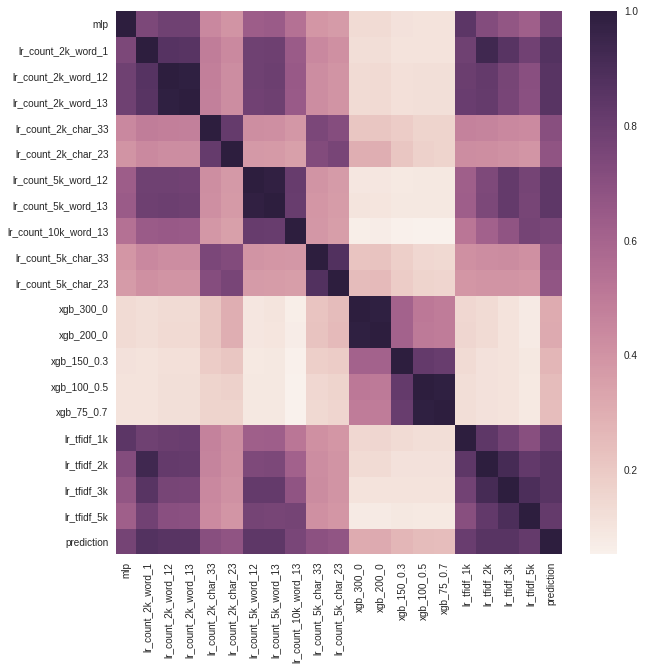

In [95]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(pr.corr())

### Metrics

In [96]:
from sklearn.metrics import auc, roc_curve, f1_score, confusion_matrix, roc_auc_score

In [97]:
pr.shape

(2912, 21)

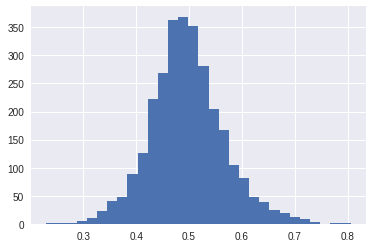

In [98]:
plt.hist(pr.prediction.values, bins=30);

In [100]:
f1_score(y_t, pr.prediction.values > 0.4)

0.65308079597218893

In [101]:
# fpr, tpr = roc_curve(y_t, pr.drop('prediction', axis=1).values)
fpr, tpr, _ = roc_curve(y_t, pr.prediction.values)

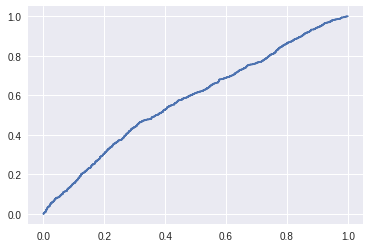

In [191]:
plt.plot(fpr, tpr)

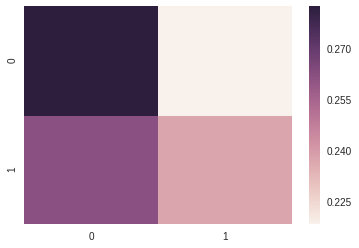

In [104]:
cm = confusion_matrix(y_t, (pr.prediction.values > 0.5).astype(int))
cm =  cm / cm.sum() #[np.newaxis]
sns.heatmap(cm)

### Selection model with l1 lr

In [112]:
lr = lm.LogisticRegression('l1', C=0.5)
lr.fit(pr.drop('prediction', axis=1).values, y_t)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [113]:
sorted(list(zip(pr.columns[:-1], lr.coef_.ravel())), key=lambda x: x[1])

[('xgb_200_0', -0.4177348602438728),
 ('xgb_300_0', -0.12227346140746116),
 ('lr_count_5k_char_23', -0.054779452799893401),
 ('mlp', 0.0),
 ('lr_count_2k_word_12', 0.0),
 ('lr_count_2k_word_13', 0.0),
 ('lr_count_2k_char_33', 0.0),
 ('lr_count_5k_word_13', 0.0),
 ('lr_count_10k_word_13', 0.0),
 ('lr_count_5k_char_33', 0.0),
 ('xgb_150_0.3', 0.0),
 ('xgb_100_0.5', 0.0),
 ('xgb_75_0.7', 0.0),
 ('lr_tfidf_1k', 0.0),
 ('lr_tfidf_2k', 0.0),
 ('lr_tfidf_3k', 0.0),
 ('lr_tfidf_5k', 0.0),
 ('lr_count_2k_word_1', 0.036944243194485075),
 ('lr_count_5k_word_12', 0.36648562950872987),
 ('lr_count_2k_char_23', 1.1721606052071658)]

In [107]:
best = list(filter(lambda x: x[1] != 0.0, zip(pr.columns[:-1], lr.coef_.ravel())))
best_model_names = [x[0] for x in best]

In [108]:
len(best)

3

## Using best models

Choosing the best models based on single comment score, user score and coef before model in ridge regression on prediction from all models

### Probability prediction

In [116]:
%%time
np.random.seed(0)
fit_predict_to_n_user(comments,
        [
            LrModelTfidf('lr_tfidf_5k', 5000, penalty='l2', C=0.05),
            
            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2), penalty='l2', C=0.05),
            LrModelCount('lr_count_10k_word_13', 10000, ngram_range=(1, 3), penalty='l2', C=0.05),

            LrModelCount('lr_count_5k_char_23', 5000, 'char', (2, 3), penalty='l2', C=0.05),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3), penalty='l2', C=0.05),
        ], 11, False, with_additional=True, debug=True, predict_proba=True)

1567 - uniq peoples
5054 - additional peoples
Before sampling:
0.0    80268
1.0    59765
Name: is_gum, dtype: int64
Additional comments:
14623
Accuracy for comment:
Model:  lr_tfidf_5k
0.521930962886
Model:  lr_count_5k_word_12
0.522709576953
Model:  lr_count_10k_word_13
0.522190500908
Model:  lr_count_5k_char_23
0.525564495199
Model:  lr_count_2k_char_23
0.523228652998
Mean of models: 0.529976641578
Accuracy for user:
Model:  lr_tfidf_5k
0.550955414013
Model:  lr_count_5k_word_12
0.570063694268
Model:  lr_count_10k_word_13
0.582802547771
Model:  lr_count_5k_char_23
0.582802547771
Model:  lr_count_2k_char_23
0.53821656051
Median of models averaged per user:
0.579617834395
Median of averaged model per user:
0.579617834395
CPU times: user 2min 2s, sys: 1.4 s, total: 2min 3s
Wall time: 1min 40s


Probability is better

## Predicting for one user in a wild

### AverageModel

In [120]:
class AverageModel():
    def __init__(self, models):
        self.models = models
        self._fitted = False
    
    def fit(self, X, y):
        for m in self.models:
            m.fit(X, y)
        self._fitted = True
    
    def predict(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        
        predictions = np.hstack([np.expand_dims(m.predict(X), -1) for m in self.models])
        predictions = (np.median(predictions, axis=1) > 0.5).astype(int)
        return predictions
    
    def predict_proba(self, X):
        if not self._fitted:
            raise Exception('Not fitted yet')
        
        predictions = []
        for model in self.models:
            prediction = model.predict_proba(X)
            if prediction.shape[1] > 1:
                prediction = prediction[:, 1]
            else:
                prediction = prediction.ravel()
            predictions.append(prediction)
                
        predictions = np.hstack([np.expand_dims(p, -1) for p in predictions])
        predictions = np.mean(predictions, axis=1)
        return predictions

In [121]:
av_model = AverageModel([
            LrModelTfidf('lr_tfidf_5k', 5000, penalty='l2', C=0.05),
            
            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2), penalty='l2', C=0.05),
            LrModelCount('lr_count_10k_word_13', 10000, ngram_range=(1, 3), penalty='l2', C=0.05),

            LrModelCount('lr_count_5k_char_23', 5000, 'char', (2, 3), penalty='l2', C=0.05),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3), penalty='l2', C=0.05),
])

In [133]:
unique_ids = comments.from_id.value_counts()[comments.from_id.value_counts() >= 11].index.values
additional_ids = comments.from_id.value_counts()[comments.from_id.value_counts() < 11].index.values

train_idxs = unique_ids[:int(len(unique_ids) * 0.8)]
test_idxs = unique_ids[int(len(unique_ids) * 0.8):]

train_comments = comments[[i in train_idxs for i in comments.from_id]]
additional_comments = comments[[i in additional_ids for i in comments.from_id]]
train_comments = pd.concat((train_comments.reset_index(drop=True), additional_comments.reset_index(drop=True)))

test_comments = comments[[i in test_idxs for i in comments.from_id]]

train_comments = make_df_balanced(train_comments, 'is_gum')

X_train, X_test = train_comments, test_comments
y_train, y_test = train_comments.is_gum.values, test_comments.is_gum.values

In [134]:
av_model.fit(X_train, y_train)

In [135]:
pr = av_model.predict(X_test)

In [605]:
accuracy_score(y_test, pr)

0.5545531435015506

In [293]:
pr = av_model.predict_proba(X_test)

In [158]:
pd.Series.value_counts((pr > 0.493).astype(int), True)

0    0.504801
1    0.495199
dtype: float64

In [140]:
pd.Series.value_counts(y_test, True)

0.0    0.542954
1.0    0.457046
dtype: float64

In [144]:
pd.Series.value_counts(y_train, True)

1.0    0.5
0.0    0.5
dtype: float64

In [609]:
accuracy_score(y_test, pr > 0.5)

0.56357485198759516

In [164]:
test_comments.iloc[av_model.predict_proba(X_test).argmax()].text

'имя а вы себя к людям не причисляете?)или вы тоже скотина?'

In [165]:
test_comments.iloc[av_model.predict_proba(X_test).argmax()].is_gum

1.0

In [160]:
test_comments.iloc[av_model.predict_proba(X_test).argmin()].text

'Стикер типичного воронежа, воронежец был на отдыхе взял листовку у промоутера ,а отдал стикер ТВ'

In [166]:
test_comments.iloc[av_model.predict_proba(X_test).argmin()].is_gum

0.0

In [128]:
my_coms = ['Эй ты а ну быро отошел от моей машины!!!',
           'Вчера на вогресе такую аварию видел',
           'Слышали, проезд до 17р подорожал?)']

In [129]:
my_coms_df = pd.DataFrame(my_coms, columns=['text'])

In [130]:
av_model.predict_proba(my_coms_df)

array([ 0.45336975,  0.36736823,  0.37585673])

## ELI5

In [173]:
import eli5

In [217]:
lr_model = LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2), penalty='l2', C=0.05)
lr_model_char = LrModelCount('lr_count_5k_char_23', 5000, 'char', (2, 3), penalty='l2', C=0.05)
lr_model_tfidf = LrModelTfidf('lr_tfidf_5k', 5000, penalty='l2', C=0.05)

In [218]:
lr_model.fit(X_train, y_train)
lr_model_char.fit(X_train, y_train)
lr_model_tfidf.fit(X_train, y_train)

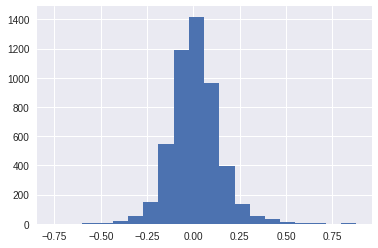

In [219]:
plt.hist(lr_model_tfidf.model.coef_.ravel(), bins=20);

In [199]:
lr_model.model.intercept_

array([-0.15163359])

In [201]:
lr_model_char.model.intercept_

array([-0.18374788])

In [220]:
lr_model_tfidf.model.intercept_

array([-0.12873058])

In [196]:
eli5.show_weights(lr_model.model, vec=lr_model.vectorizer, top=(20, 20))

Weight?,Feature
+0.894,ващще
+0.787,кошмар
+0.785,приветик
+0.723,согласна
+0.662,вика
+0.637,видела
+0.635,фига
+0.620,хотела
+0.616,о_о
+0.596,хи


In [198]:
eli5.show_weights(lr_model_char.model, vec=lr_model_char.vectorizer, top=(20, 20))

Weight?,Feature
+1.093,^^
+0.607,я )
+0.583,)н
+0.560,😊
+0.539,м)
+0.498,;)
+0.488,нот
+0.486,^
+0.453,т)
+0.448,.)


In [221]:
eli5.show_weights(lr_model_tfidf.model, vec=lr_model_tfidf.vectorizer, top=(20, 20))

Weight?,Feature
+0.879,приветик
+0.827,видела
+0.820,согласна
+0.748,кошмар
+0.738,поняла
+0.713,ващще
+0.687,ночки
+0.650,очень
+0.613,о_о
+0.610,личку


In [283]:
i = 200
print(y_train[i])

1.0


In [284]:
eli5.show_prediction(lr_model.model, X_train.text.iloc[i], vec=lr_model.vectorizer)

In [285]:
eli5.show_prediction(lr_model_char.model, X_train.text.iloc[i], vec=lr_model_char.vectorizer)

In [286]:
eli5.show_prediction(lr_model_tfidf.model, X_train.text.iloc[i], vec=lr_model_tfidf.vectorizer)

In [287]:
from eli5.lime import TextExplainer
te = TextExplainer()

def dummy_predict_proba(docs):
    d = pd.DataFrame({'text': docs})
    
    predictions = []
    for model in av_model.models:
        prediction = model.predict_proba(d)
        predictions.append(prediction)

    pr = predictions[0]
    for i in range(1, len(av_model.models)):
        pr += predictions[1]
    return pr / len(av_model.models)

In [288]:
te.fit(X_train.text.iloc[i], dummy_predict_proba);

In [289]:
te.show_prediction()

### For different n

In [167]:
%%time
np.random.seed(0)
scores = []
for i in range(1, 21):
    sc = fit_predict_to_n_user(comments,
            [
            LrModelTfidf('lr_tfidf_5k', 5000, penalty='l2', C=0.05),
            
            LrModelCount('lr_count_5k_word_12', 5000, ngram_range=(1, 2), penalty='l2', C=0.05),
            LrModelCount('lr_count_10k_word_13', 10000, ngram_range=(1, 3), penalty='l2', C=0.05),

            LrModelCount('lr_count_5k_char_23', 5000, 'char', (2, 3), penalty='l2', C=0.05),
            LrModelCount('lr_count_2k_char_23', 2000, 'char', (2, 3), penalty='l2', C=0.05),
            ], i, False, with_additional=True, debug=False)
    scores.append(sc)

Accuracy for comment:
Model:  lr_tfidf_5k
0.516226415094
Model:  lr_count_5k_word_12
0.507924528302
Model:  lr_count_10k_word_13
0.512452830189
Model:  lr_count_5k_char_23
0.521509433962
Model:  lr_count_2k_char_23
0.518490566038
Median of models: 0.513962264151
Accuracy for user:
Model:  lr_tfidf_5k
0.516226415094
Model:  lr_count_5k_word_12
0.507924528302
Model:  lr_count_10k_word_13
0.512452830189
Model:  lr_count_5k_char_23
0.521509433962
Model:  lr_count_2k_char_23
0.518490566038
Median of models averaged per user:
0.513962264151
Median of averaged model per user:
0.513962264151
Accuracy for comment:
Model:  lr_tfidf_5k
0.519509476031
Model:  lr_count_5k_word_12
0.545707915273
Model:  lr_count_10k_word_13
0.544593088071
Model:  lr_count_5k_char_23
0.513935340022
Model:  lr_count_2k_char_23
0.517279821628
Median of models: 0.535674470457
Accuracy for user:
Model:  lr_tfidf_5k
0.532887402453
Model:  lr_count_5k_word_12
0.540691192865
Model:  lr_count_10k_word_13
0.545150501672
Model

Accuracy for comment:
Model:  lr_tfidf_5k
0.543710539097
Model:  lr_count_5k_word_12
0.534725594949
Model:  lr_count_10k_word_13
0.539825157844
Model:  lr_count_5k_char_23
0.5403108305
Model:  lr_count_2k_char_23
0.539825157844
Median of models: 0.54613890238
Accuracy for user:
Model:  lr_tfidf_5k
0.616935483871
Model:  lr_count_5k_word_12
0.576612903226
Model:  lr_count_10k_word_13
0.568548387097
Model:  lr_count_5k_char_23
0.616935483871
Model:  lr_count_2k_char_23
0.584677419355
Median of models averaged per user:
0.616935483871
Median of averaged model per user:
0.629032258065
Accuracy for comment:
Model:  lr_tfidf_5k
0.546740172579
Model:  lr_count_5k_word_12
0.541946308725
Model:  lr_count_10k_word_13
0.542186001918
Model:  lr_count_5k_char_23
0.547219558965
Model:  lr_count_2k_char_23
0.553211888782
Median of models: 0.550575263663
Accuracy for user:
Model:  lr_tfidf_5k
0.623931623932
Model:  lr_count_5k_word_12
0.568376068376
Model:  lr_count_10k_word_13
0.594017094017
Model:  

In [168]:
%matplotlib inline

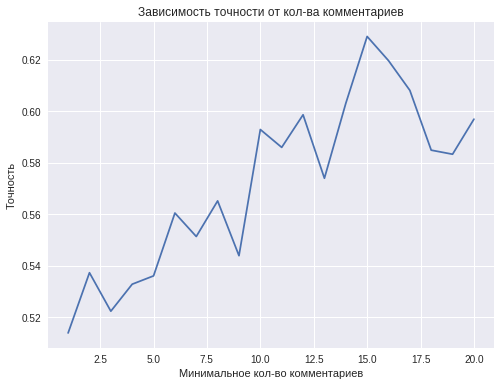

In [169]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(1, 21), [x[1] for x in scores])
# plt.plot(range(3, 21), [x[1] for x in scores])
# plt.yticks(np.round(np.linspace(0.51, 0.66, 16), 2));
# plt.xticks(np.linspace(0, 16, 17));
# plt.ylim(0.51, 0.66)
# plt.xlim(0, 16)
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Точность')
plt.title('Зависимость точности от кол-ва комментариев');

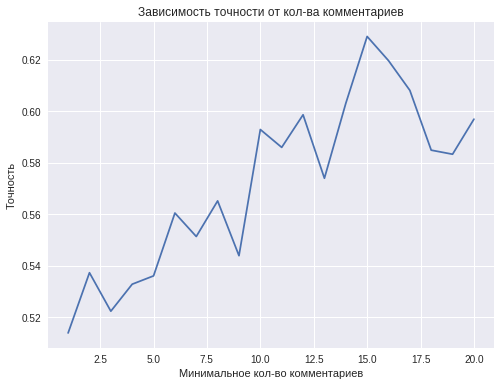

In [290]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(1, 21), [x[1] for x in scores])
# plt.plot(range(3, 21), [x[1] for x in scores])
# plt.yticks(np.round(np.linspace(0.51, 0.66, 16), 2));
# plt.xticks(np.linspace(0, 16, 17));
# plt.ylim(0.51, 0.66)
# plt.xlim(0, 16)
plt.xlabel('Минимальное кол-во комментариев')
plt.ylabel('Точность')
plt.title('Зависимость точности от кол-ва комментариев');

In [291]:
fig.savefig('temp3.png')